In [ ]:
# !pip install -r requirements.txt

# !conda install seaborn -y

# !conda install wordcloud -y

# !conda install nltk -y

In [7]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS
from nltk.corpus import stopwords
import re
import os

import warnings
warnings.filterwarnings('ignore')

# 1. Carregamento dos dados

In [8]:
path = 'Review-Imdb/'
positiveFiles = [x for x in os.listdir(path+"train/pos/") if x.endswith(".txt")]
negativeFiles = [x for x in os.listdir(path+"train/neg/") if x.endswith(".txt")]
testPosFiles = [x for x in os.listdir(path+"test/pos/") if x.endswith(".txt")]
testNegFiles = [x for x in os.listdir(path+"test/neg/") if x.endswith(".txt")]

In [9]:
display(len(positiveFiles))
display(len(negativeFiles))
display(len(testPosFiles))
display(len(testNegFiles))

12500

12500

12500

12500

In [10]:
# Abrindo cada arquivo .txt e adicionando o conteudo ao vetor correspondente

positiveReviews, negativeReviews, testPosReviews, testNegReviews = [], [], [], []
for pfile in positiveFiles:
    with open(path+"train/pos/"+pfile, encoding="latin1") as f:
        positiveReviews.append(f.read())
for nfile in negativeFiles:
    with open(path+"train/neg/"+nfile, encoding="latin1") as f:
        negativeReviews.append(f.read())
for tfile in testPosFiles:
    with open(path+"test/pos/"+tfile, encoding="latin1") as f:
        testPosReviews.append(f.read())
for tfile in testNegFiles:
    with open(path+"test/neg/"+tfile, encoding="latin1") as f:
        testNegReviews.append(f.read())

In [11]:
# Juntando todas as reviews em apenas um dataset

reviews = pd.concat([
    pd.DataFrame({"review":positiveReviews, "label":1, "file":positiveFiles}),
    pd.DataFrame({"review":negativeReviews, "label":0, "file":negativeFiles}),
    pd.DataFrame({"review":testPosReviews, "label":-1, "file":testPosFiles}),
    pd.DataFrame({"review":testNegReviews, "label":-1, "file":testNegFiles})
], ignore_index=True).sample(frac=1, random_state=1).reset_index(drop=True)
reviews.head()

,review,label,file
0,Gilmore Girls is a hilarious show with never e...,-1,3206_10.txt
1,The net is an excellent movie! It's about Ange...,-1,8217_8.txt
2,"This film flopped miserably in the UK, and it ...",-1,994_7.txt
3,"Oh boy, where do I go with this one? Herendous...",0,10518_1.txt
4,This movie is a great mocumentary. It follows ...,1,8136_9.txt


In [12]:
reviews.shape

(50000, 3)

# 2. Exploração dos dados

* Adicionando ao dataset de treino as reviews que possuem as labels 0 (negativo) e 1 (positivo).
* Adicionando ao dataset de teste as reviews que possuem aa labels -1 (teste, tanto negativa quanto positiva).

In [13]:
train = reviews[reviews.label!=-1].sample(frac=0.7, random_state=42) #.reset_index(drop=True)
valid = reviews[reviews.label!=-1].drop(train.index)
test = reviews[reviews.label==-1].reset_index(drop=True)

In [14]:
print(train.shape)
print(valid.shape)
print(test.shape)

(17500, 3)
(7500, 3)
(25000, 3)


In [15]:
print("Treino.")
display(train.head())
print("Valid.")
display(valid.head())
print("Teste.")
display(test.head())

Treino.


,review,label,file
13533,"This movie started out good, i felt like i was...",0,12229_3.txt
47978,Anything that might have been potentially inte...,0,11840_4.txt
19168,A visit by Hitler in Rome is the backdrop of t...,1,3368_8.txt
27126,Richard Widmark is a tainted character in this...,1,4189_8.txt
27901,I was very impressed with this film. I would h...,1,6939_9.txt


Valid.


,review,label,file
4,This movie is a great mocumentary. It follows ...,1,8136_9.txt
20,Paris Je T ' aime is a movie that explores the...,1,3681_8.txt
24,After hearing the word of mouth of just how ba...,0,750_1.txt
26,I had to give this film a 1 because it's that ...,0,12478_1.txt
32,"a timeless classic, wonderfully acted with per...",1,4839_10.txt


Teste.


,review,label,file
0,Gilmore Girls is a hilarious show with never e...,-1,3206_10.txt
1,The net is an excellent movie! It's about Ange...,-1,8217_8.txt
2,"This film flopped miserably in the UK, and it ...",-1,994_7.txt
3,"The movie doesn't take itself seriously, and i...",-1,4235_7.txt
4,This is definitely one of the weaker of the se...,-1,3896_1.txt


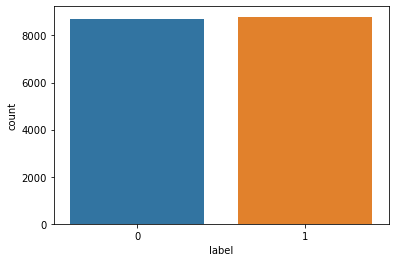

In [16]:
sns.countplot(train['label']);

O Grafico mostra que lidamos com um dataset perfeitamente balanceado. Isso é bom porque a análise será mais fácil de entender e interpretar a métrica de acurácia do modelo.

In [17]:
# Função para mostrar o wordcloud das palavras que mais aparecem nas reviews.

def plot_wordcloud(data, title):
    wordcloud = WordCloud(background_color='black',
                          stopwords=set(STOPWORDS),
                          max_words=200,
                          max_font_size=100,
                          random_state=17,
                          width=800,
                          height=400,
                          mask=None)
    wordcloud.generate(str(data))
    plt.figure(figsize=(15.0,10.0))
    plt.axis('off')
    plt.title(title)
    plt.imshow(wordcloud);

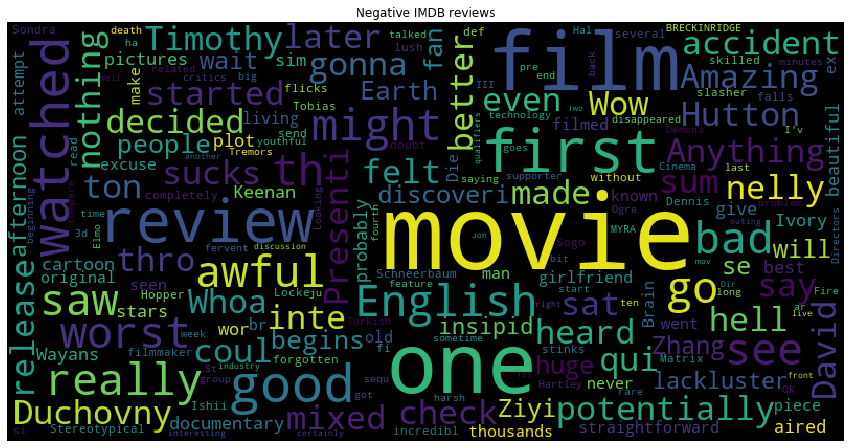

In [18]:
plot_wordcloud(train.loc[train['label']==0]['review'], 'Negative IMDB reviews')

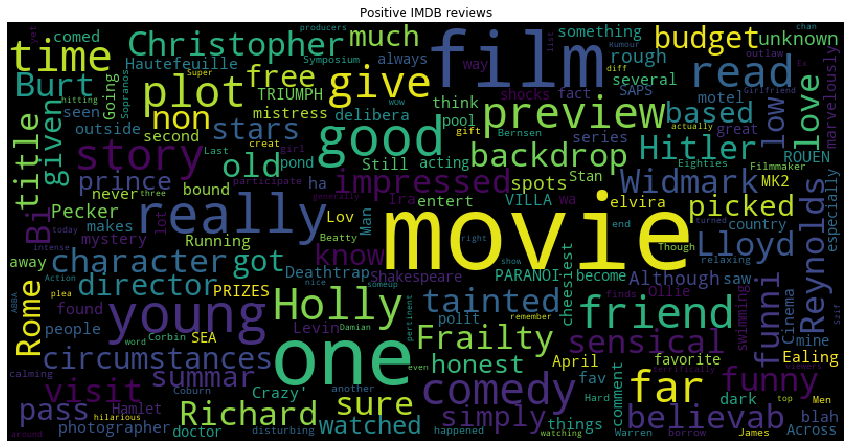

In [19]:
plot_wordcloud(train.loc[train['label']==1]['review'], 'Positive IMDB reviews')

Como podemos ver ambas as categorias as palavras que mais aparecem são "Movie" e "Film", e não é estranho, porque o dataset contem reviews de filmes.

Negative reviews contém palavras como: "Really" (pode ser usado de forma sarcástica ou para ampliar a opinião da pessoa), "Bad", "Disappointing", "Awful" (nada bom sobre o filme).

Positive reviews contém palavras como: "Best", "Epic", "Good" (que geralmente são usados para expressar a satisfação de alguém).

# 3. Pré-Processamento

In [22]:
nltk.download('stopwords')

stopWords = stopwords.words('english')

[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


* Função para limpar o dataset onde:
    * os carateres especiais são removidos
    * todas as letras são convertidas para lowercase

In [23]:
def CleanData(sentence):
    processedList = ""
    
    #convert to lowercase and ignore special charcter
    sentence = re.sub(r'[^A-Za-z0-9\s.]', r'', str(sentence).lower())
    sentence = re.sub(r'\n', r' ', sentence)
    
    sentence = " ".join([word for word in sentence.split() if word not in stopWords])
    
    return sentence

In [24]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17500 entries, 13533 to 1749
Data columns (total 3 columns):
review    17500 non-null object
label     17500 non-null int64
file      17500 non-null object
dtypes: int64(1), object(2)
memory usage: 1.2+ MB


In [25]:
# Review sem o processamento

train['review'].iloc[0]

'This movie started out good, i felt like i was watching an adult version of Seinfeld. Much to quickly i started questioning the situations and actions of the main characters, and found no answers to why they were doing what they were doing. All the acting was superb but only a few scenes had brief moments where they were actually funny. Dan Cortese was amazing. I loved him in this role. His agent should show this movie to casting agents. Watch the first few scenes and then find something better, or else you will find yourself totally lost in this mess. I found this in a bin at a video store. It cost me two dollars and due to the rareness of this movie i feel like it was a good price.'

In [26]:
# Review Com o processamento

CleanData(train['review'].iloc[0])

'movie started good felt like watching adult version seinfeld. much quickly started questioning situations actions main characters found answers doing. acting superb scenes brief moments actually funny. dan cortese amazing. loved role. agent show movie casting agents. watch first scenes find something better else find totally lost mess. found bin video store. cost two dollars due rareness movie feel like good price.'

In [27]:
train['processed_reviews'] = train['review'].map(lambda x: CleanData(x))
valid['processed_reviews'] = valid['review'].map(lambda x: CleanData(x))
test['processed_reviews'] = test['review'].map(lambda x: CleanData(x))

In [28]:
display(train.head())
display(valid.head())
display(test.head())

,review,label,file,processed_reviews
13533,"This movie started out good, i felt like i was...",0,12229_3.txt,movie started good felt like watching adult ve...
47978,Anything that might have been potentially inte...,0,11840_4.txt,anything might potentially interesting materia...
19168,A visit by Hitler in Rome is the backdrop of t...,1,3368_8.txt,visit hitler rome backdrop tender story love f...
27126,Richard Widmark is a tainted character in this...,1,4189_8.txt,richard widmark tainted character movie. profe...
27901,I was very impressed with this film. I would h...,1,6939_9.txt,impressed film. would rate one better classice...


,review,label,file,processed_reviews
4,This movie is a great mocumentary. It follows ...,1,8136_9.txt,movie great mocumentary. follows rap group nwh...
20,Paris Je T ' aime is a movie that explores the...,1,3681_8.txt,paris je aime movie explores different kinds a...
24,After hearing the word of mouth of just how ba...,0,750_1.txt,hearing word mouth bad film took plunge bought...
26,I had to give this film a 1 because it's that ...,0,12478_1.txt,give film 1 bad dont make think didnt enjoy wa...
32,"a timeless classic, wonderfully acted with per...",1,4839_10.txt,timeless classic wonderfully acted perfect loc...


,review,label,file,processed_reviews
0,Gilmore Girls is a hilarious show with never e...,-1,3206_10.txt,gilmore girls hilarious show never ending sarc...
1,The net is an excellent movie! It's about Ange...,-1,8217_8.txt,net excellent movie angela bennettin great per...
2,"This film flopped miserably in the UK, and it ...",-1,994_7.txt,film flopped miserably uk didnt deserve to. tr...
3,"The movie doesn't take itself seriously, and i...",-1,4235_7.txt,movie doesnt take seriously follow lead youre ...
4,This is definitely one of the weaker of the se...,-1,3896_1.txt,definitely one weaker series carry films. lack...


## 3.1 Wordcloud das reviews negativas, antes e depois do processamento.

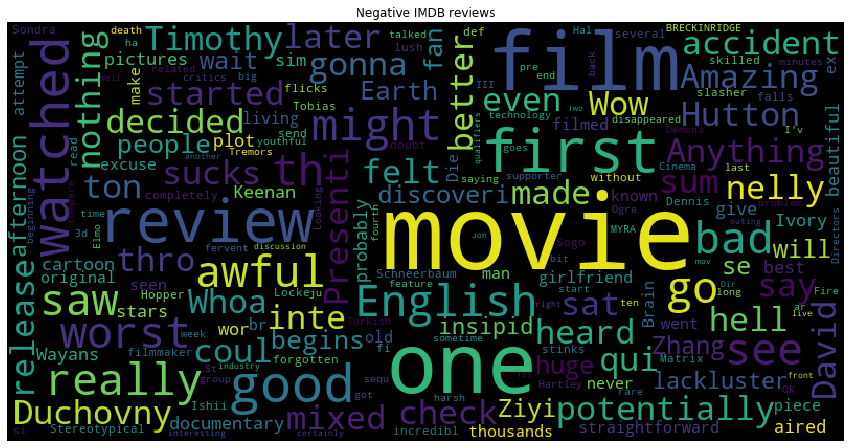

In [29]:
plot_wordcloud(train.loc[train['label']==0]['review'], 'Negative IMDB reviews')

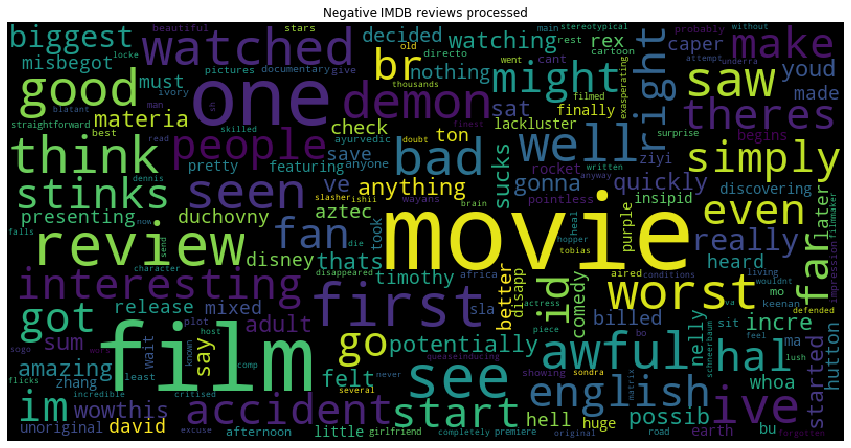

In [30]:
plot_wordcloud(train.loc[train['label']==0]['processed_reviews'], 'Negative IMDB reviews processed')

## 3.2 Wordcloud das reviews positivas, antes e depois do processamento.

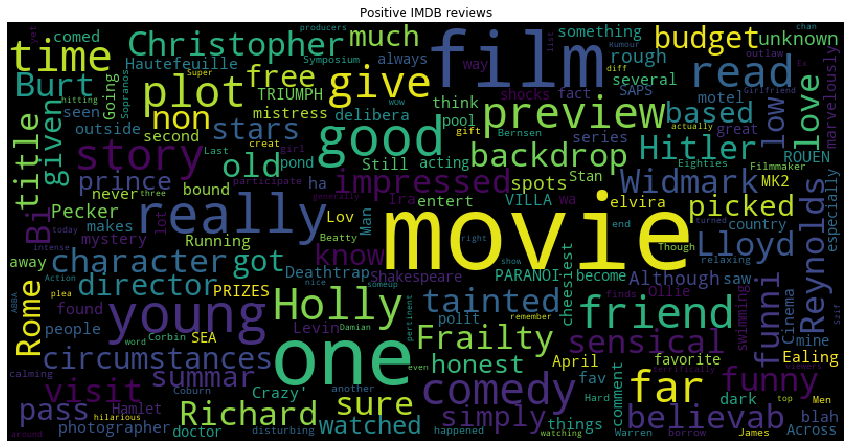

In [31]:
plot_wordcloud(train.loc[train['label']==1]['review'], 'Positive IMDB reviews')

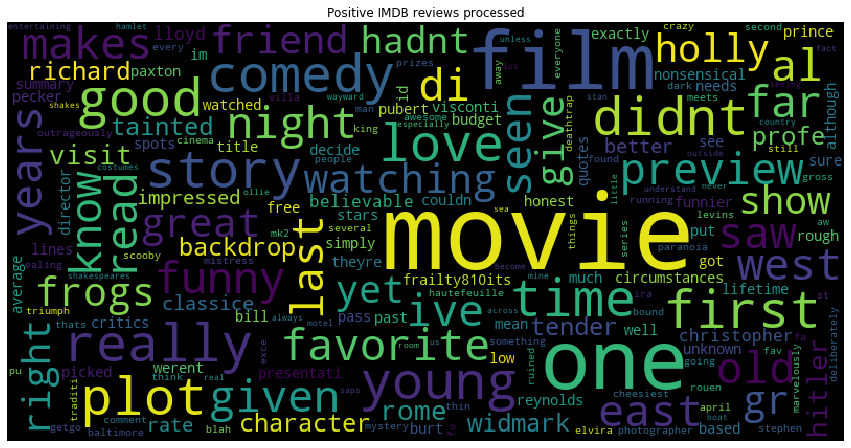

In [32]:
plot_wordcloud(train.loc[train['label']==1]['processed_reviews'], 'Positive IMDB reviews processed')